In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

<h1>Finding planets with the Kepler space mission data</h1>

The data from the Kepler space mission is publicly available, and there is an easy-to-use Python package to do some basic analysis, which we will use in this notebook. For more information, and a lot of examples, see [here](https://docs.lightkurve.org/index.html). Below, the very basics are shown of how to get from raw Kepler data to a planetary candidate. 

<h2>Raw light curve</h2>

First, we select the raw data of a particular Kepler system. Kepler-10 by default, but this can be changed in the relevant input box (note that hitting \<Enter\> after changing the number has no effect; instaead hit \<Tab\>). The flux is given in the number of electrons per second. The lightcurve always shows long-period trends that have nothing to do with any transits (brightening of the star, instrumental effects?). We would like to subtract these trends to end up with (possible) transits on a constant background. The long-term trends are determined using a high-pass filter called [Savitzky-Golay](https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter) (the details are not important). Click on the "Show trend" button to show the long-term trend, and convince yourself that it does a reasonable job of following the overall shape of the lightcurve.

BoundedIntText(value=10, description='Kepler #:', max=1500, min=1)

Output()

Button(description='Show trend', icon='check', style=ButtonStyle(), tooltip='Show trend')

Output()

<IPython.core.display.Javascript object>


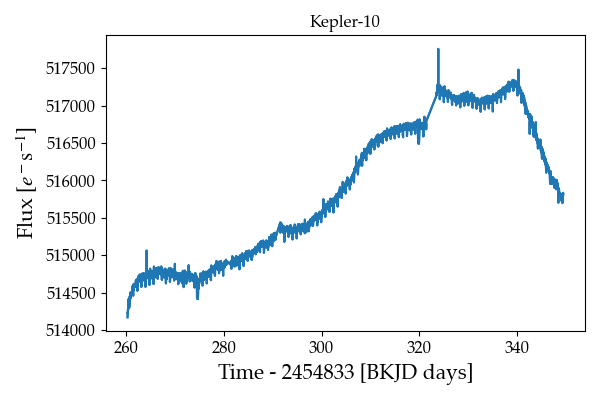

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, update_display, HTML
import ipywidgets as widgets

import lightkurve as lk

# Try and make plots look nice
plt.rcParams["font.family"] = 'serif'
plt.rcParams["mathtext.fontset"] = 'stix'
plt.rcParams["font.serif"] = 'Palatino'
plt.rcParams['pdf.fonttype'] = 42
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')


w_kep = widgets.BoundedIntText(
    value=10,
    min=1,
    max=1500,
    step=1,
    description='Kepler #:',
    disabled=False
)

# Display int input
output = widgets.Output()
display(w_kep, output)

w_trend=widgets.Button(
    description='Show trend',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Show trend',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

# Display button
output = widgets.Output()
display(w_trend, output)

name = "Kepler-{}".format(w_kep.value)
tpf = lk.search_targetpixelfile(name, quarter=3).download()
lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)

fig1 = plt.figure(figsize=(6,4),num='Raw light curve')
ax1 = plt.gca()

raw_plot, = ax1.plot(lc.time, lc.flux, color=u'#1f77b4')
trend_plot, = ax1.plot(lc.time, lc.flux, color=u'#1f77b4')

ax1.set_xlabel(r'Time - 2454833 [BKJD days]', fontsize=15)
ax1.set_ylabel(r'Flux [$e^-{\rm s}^{-1}$]', fontsize=15)
ax1.set_title(name)

plt.tight_layout()

def on_value_change(change):
    with output:
        global lc, name
        name = "Kepler-{}".format(w_kep.value)
        tpf = lk.search_targetpixelfile(name, quarter=3).download()
        lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
        
        raw_plot.set_data(lc.time, lc.flux)
        trend_plot.set_data(lc.time, lc.flux)
        trend_plot.set_color(u'#1f77b4')
        
        ax1.set_title(name)
        ax1.relim()
        ax1.autoscale()

w_kep.observe(on_value_change, names='value')

def on_button_clicked(b):
    with output:
        flat, trend = lc.flatten(window_length=301, return_trend=True)
        trend_plot.set_data(trend.time, trend.flux)
        trend_plot.set_color('red')

w_trend.on_click(on_button_clicked)


<h2>Flat Lightcurve</h2>

Now, we can subtract the trend from the lightcurve, to obtain what is sometimes called a 'flat lightcurve'. The most obvious transits (i.e. Hot Jupiters) can be easily spotted at this point if they are present. After changing the Kepler number above, hit 'Update' to refresh the plot.

Button(description='Update', icon='check', style=ButtonStyle(), tooltip='Update')

Output()

<IPython.core.display.Javascript object>


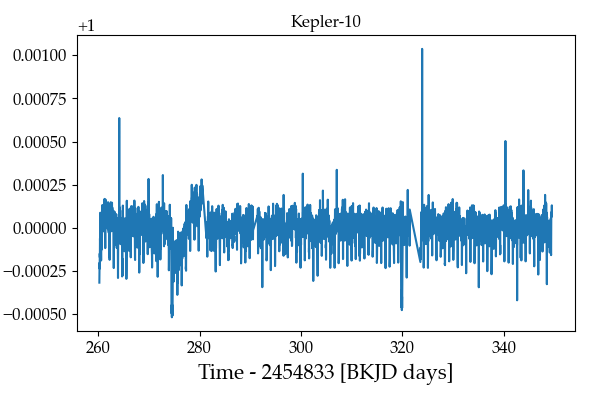

In [3]:
w_flat=widgets.Button(
    description='Update',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Update',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

# Display button
output = widgets.Output()
display(w_flat, output)

fig2 = plt.figure(figsize=(6,4),num='Flat light curve')
ax2 = plt.gca()

ax2.set_xlabel(r'Time - 2454833 [BKJD days]', fontsize=15)
ax2.set_ylabel(r'Flux [$e^-{\rm s}^{-1}$]', fontsize=15)
ax2.set_title(name)

plt.tight_layout()

flat, trend = lc.flatten(window_length=301, return_trend=True)
flat_plot, = ax2.plot(flat.time, flat.flux, color=u'#1f77b4')

def on_button_clicked(b):
    with output:
        global flat, trend
        flat, trend = lc.flatten(window_length=301, return_trend=True)
        flat_plot.set_data(flat.time, flat.flux)

        ax2.set_title(name)
        ax2.relim()
        ax2.autoscale()

w_flat.on_click(on_button_clicked)


<h2>Determining the period</h2>

The next step is to determine whether there is a periodic dimming present in the flat lightcurve. You can think of this as doing a [Fourier transform](https://en.wikipedia.org/wiki/Fourier_transform) and look for the period where there is the highest power. In cases where the signal is very far from sinusoidal, other algorithms perform better than the Fourier transform. Here, we use a special algorithm for transits, called the [Box Least Squares](https://docs.astropy.org/en/stable/timeseries/bls.html) periodogram. Its output is very similar to a Fourier transform: power as a function of period (or frequency). The slider below can be used to change the search range for periods.

Button(description='Update', icon='check', style=ButtonStyle(), tooltip='Update')

Output()

FloatRangeSlider(value=(0.3, 1.5), continuous_update=False, description='Period range:', max=20.0, min=0.1, re…

Output()

<IPython.core.display.Javascript object>


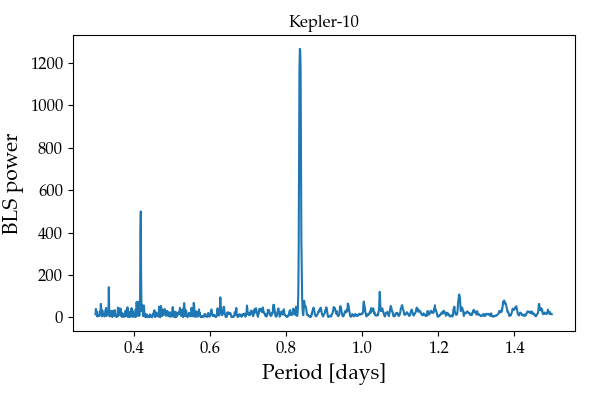

In [4]:
w_period=widgets.Button(
    description='Update',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Update',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

w_period_range=widgets.FloatRangeSlider(
    value=[0.3, 1.5],
    min=0.1,
    max=20.0,
    step=0.1,
    description='Period range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

# Display button
output = widgets.Output()
display(w_period, output)
display(w_period_range, output)

fig3 = plt.figure(figsize=(6,4),num='Periodogram')
ax3 = plt.gca()

ax3.set_xlabel(r'Period [days]', fontsize=15)
ax3.set_ylabel(r'BLS power', fontsize=15)
ax3.set_title(name)

plt.tight_layout()

periodogram = flat.to_periodogram(method="bls", 
                                  period=np.arange(w_period_range.value[0], w_period_range.value[1], 0.001))
period_plot, = ax3.plot(1/periodogram.frequency, periodogram.power)

def on_button_clicked(b):
    with output:
        global periodogram
        #periodogram = flat.to_periodogram(method="bls", period=np.arange(0.3, 3, 0.001))
        periodogram = flat.to_periodogram(method="bls", 
                                          period=np.arange(w_period_range.value[0], w_period_range.value[1], 0.001))
        period_plot.set_data(1/periodogram.frequency, periodogram.power)

        ax3.set_title(name)
        ax3.relim()
        ax3.autoscale()

w_period.on_click(on_button_clicked)

def on_value_change(change):
    with output:
        global periodogram
        #periodogram = flat.to_periodogram(method="bls", period=np.arange(0.3, 3, 0.001))
        periodogram = flat.to_periodogram(method="bls", 
                                          period=np.arange(w_period_range.value[0], w_period_range.value[1], 0.001))
        period_plot.set_data(1/periodogram.frequency, periodogram.power)

        ax3.set_title(name)
        ax3.relim()
        ax3.autoscale()

w_period_range.observe(on_value_change, names='value')

<h2>Folding the lightcurve</h2>

We can use the period $P$ where the BLS periodogram attains maximum power to create a 'folded' lightcurve. After every $P$, we reset the time to the initial time $t_0$, so that time runs from $t_0$ to $t_0+P$ only. This time interval is then scaled to unity and renamed 'phase', which runs from $-0.5$ to $0.5$. If the total observation time is 10 $P$ (say), this means that we get 10 lightcurves on top of each other. If a strong periodic signal is present, these lightcurves will strongly overlap, so that a transit is easy to see.    

Button(description='Update', icon='check', style=ButtonStyle(), tooltip='Update')

Output()

<IPython.core.display.Javascript object>


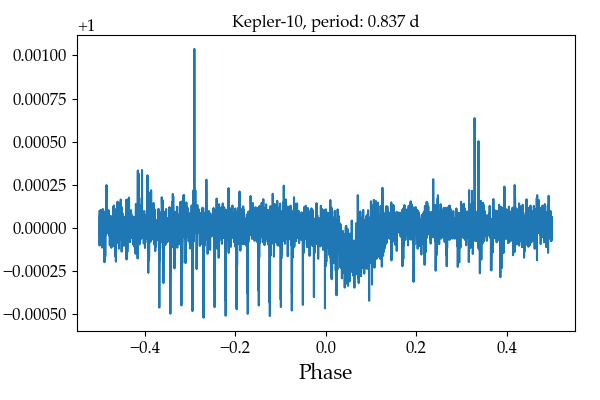

In [5]:
w_fold=widgets.Button(
    description='Update',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Update',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

# Display button
output = widgets.Output()
display(w_fold, output)

fig4 = plt.figure(figsize=(6,4),num='Folded lightcurve')
ax4 = plt.gca()

ax4.set_xlabel(r'Phase', fontsize=15)
ax4.set_ylabel(r'Flux [$e^-{\rm s}^{-1}$]', fontsize=15)
ax4.set_title(name)

plt.tight_layout()

best_fit_period = periodogram.period_at_max_power
add_name = ', period: {:.3f}'.format(best_fit_period)
ax4.set_title(name + add_name)


fld = flat.fold(period=best_fit_period, t0=periodogram.transit_time_at_max_power)
#flat.fold(period=best_fit_period, t0=periodogram.transit_time_at_max_power).errorbar()
fold_plot, = ax4.plot(fld.time, fld.flux)

def on_button_clicked(b):
    with output:
        best_fit_period = periodogram.period_at_max_power
        add_name = ', period: {:.3f}'.format(best_fit_period)

        fld = flat.fold(period=best_fit_period, t0=periodogram.transit_time_at_max_power)

        fold_plot.set_data(fld.time, fld.flux)

        ax4.set_title(name + add_name)
        ax4.relim()
        ax4.autoscale()

w_fold.on_click(on_button_clicked)
